<h1>Содержание<span class="tocSkip"></span></h1>
</li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование-по-одному-часу." data-toc-modified-id="Ресемплирование-по-одному-часу.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ресемплирование по одному часу.</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import lightgbm as lgb

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import cross_validate , train_test_split, TimeSeriesSplit, GridSearchCV 

from sklearn.metrics import mean_squared_error 

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.shape

(26496, 1)

In [4]:
data.isna().sum()

num_orders    0
dtype: int64

### Ресемплирование по одному часу.

In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

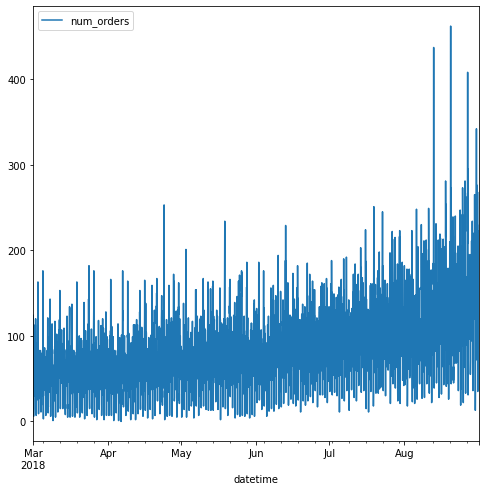

In [6]:
data.plot(figsize=(8,8))

<b>Вывод:</b> В данных отсутствуют пропуски. После ресемплирования временной интервал составляет 1 час. Данные имеют высокую частоту 

## Анализ

In [7]:
display(f'временной интервал: {data.index.max() - data.index.min()}')
data.describe()

'временной интервал: 183 days 23:00:00'

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные собраны за 183 дня. Максимлаьное количество заказов за час - 462, минимальное - 0

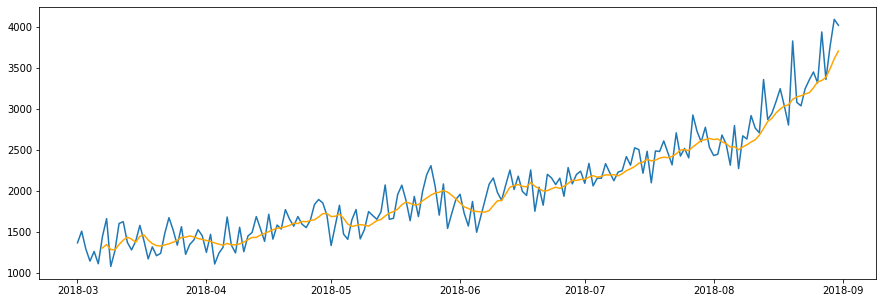

In [8]:
plt.figure(figsize=(15,5))

plt.plot(data.resample('1D').sum())
plt.plot(data.resample('1D').sum().rolling(7).mean(), color='orange')

plt.show()

Наблюдается восходящий тренд 

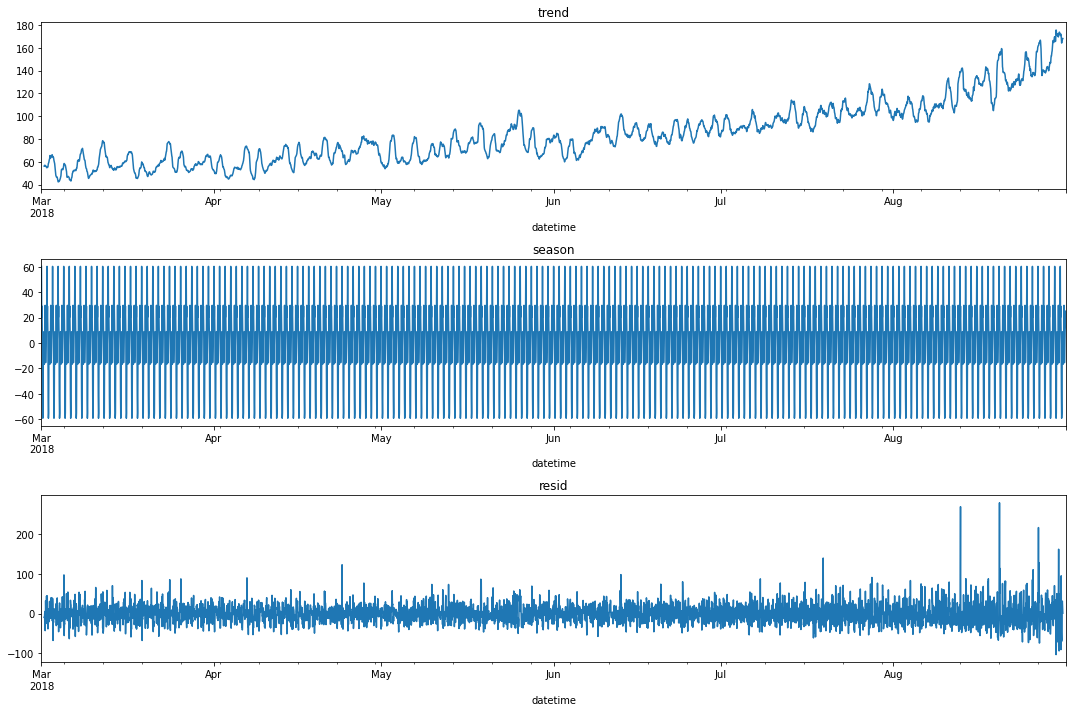

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('season')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('resid')

plt.tight_layout()




Графики показывают суточную сезонность и возрастающий тренд

In [10]:
data.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

Данные за неделю

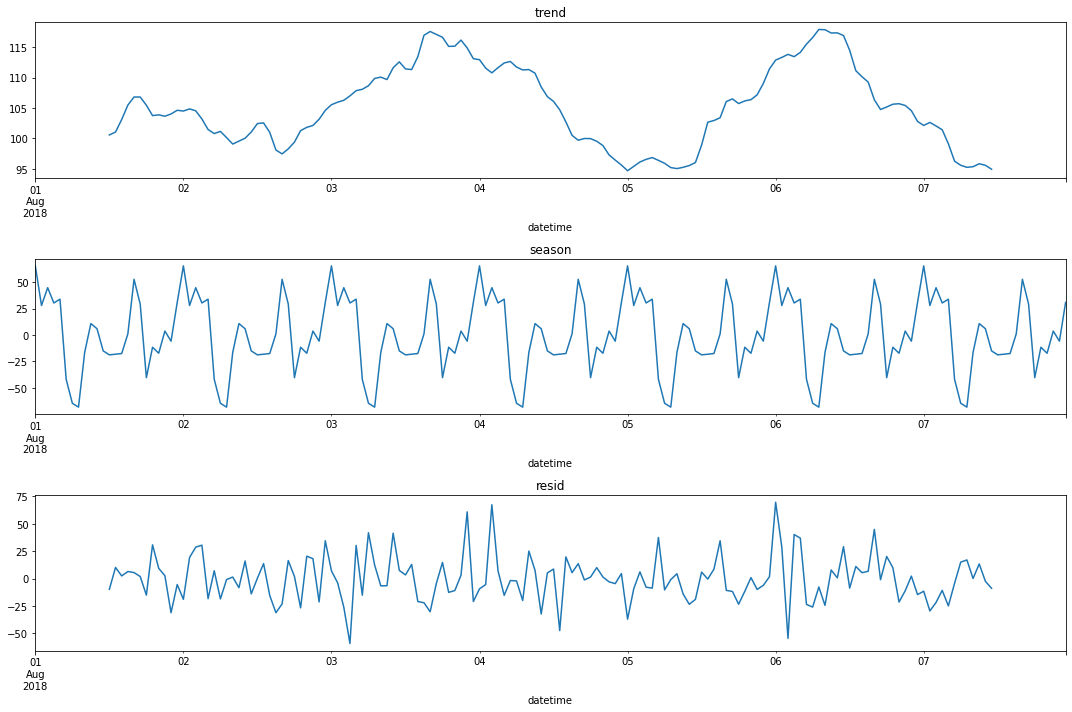

In [11]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-07'])
plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('season')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('resid')

plt.tight_layout()

Ночью заказы стремятся к 0, в вечернее время заказы возрастают

In [14]:
def features_comp(data, rolling_size, max_lag):
    data['dayofweel'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag+1):
        data[f'lag_{i}'] = data['num_orders'].shift(i)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
    data = data.dropna()
    return data



In [15]:
data = features_comp(data, 30, 20)
data.head()

,num_orders,dayofweel,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,4,6,11.0,20.0,64.0,75.0,120.0,90.0,58.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,58.133333
2018-03-02 07:00:00,7,4,7,11.0,11.0,20.0,64.0,75.0,120.0,90.0,...,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,54.366667
2018-03-02 08:00:00,46,4,8,7.0,11.0,11.0,20.0,64.0,75.0,120.0,...,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,51.766667
2018-03-02 09:00:00,45,4,9,46.0,7.0,11.0,11.0,20.0,64.0,75.0,...,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,50.933333
2018-03-02 10:00:00,54,4,10,45.0,46.0,7.0,11.0,11.0,20.0,64.0,...,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,50.233333


<b>Выводы:</b> 
       <br> Определены тренды и сезонность. 
        <br>Наблюдается рост заказов по времени. При анализе суточной сезонности выявлено, что пик заказов приходится на вечернее время, а спад происходит ночью.
          <br>  Добавлены признаки для обучения 'rolling_mean', 'lag', 'dayofweek', 'h'

## Обучение

In [16]:
RANDOM_STATE = 12345

In [17]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)

In [18]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### Линейная регрессия

In [19]:
time_cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lr = LinearRegression()
cv_lr = cross_validate(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=time_cv)

### Случайный лес

In [20]:
time_cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
parametr = {'n_estimators' : range(10, 41, 10),
            'max_depth' : range(1, 8, 2),
            'min_samples_leaf' : range(1,8),
            'min_samples_split' : range(2,8,2)}

grid_rs = GridSearchCV(model_rf,
                     parametr,
                     scoring='neg_root_mean_squared_error',
                     cv=time_cv,
                     verbose=3,
                     n_jobs=-1)
grid_rs.fit(features_train, target_train)

rmse_rf = grid_rs.best_score_*-1
grid_rs.best_params_

Fitting 3 folds for each of 336 candidates, totalling 1008 fits
[CV 1/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV 2/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV 3/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV 1/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV 2/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV 3/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV 1/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.1s
[CV 2/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.1s
[CV 3/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.1s
[CV 1/3] 

{'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 40}

{'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 40}

### LightGBM

In [21]:
time_cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lgbm = lgb.LGBMRegressor(random_state = RANDOM_STATE)
parametr = {'n_estimators' : range(10, 41, 10),
            'max_depth' : range(1, 8, 2),
            'num_leaves' : range(20,80,20)}

grid_lgbm = GridSearchCV(model_lgbm,
                     parametr,
                     scoring='neg_root_mean_squared_error',
                     cv=time_cv,
                     verbose=3,
                     n_jobs=-1)
grid_lgbm.fit(features_train, target_train)
rmse_lgbd = grid_lgbm.best_score_*-1
grid_lgbm.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END ....max_depth=1, n_estimators=10, num_leaves=20; total time=   6.4s
[CV 2/3] END ....max_depth=1, n_estimators=10, num_leaves=20; total time=   6.8s
[CV 3/3] END ....max_depth=1, n_estimators=10, num_leaves=20; total time=   6.7s
[CV 1/3] END ....max_depth=1, n_estimators=10, num_leaves=40; total time=   6.0s
[CV 2/3] END ....max_depth=1, n_estimators=10, num_leaves=40; total time=   7.2s
[CV 3/3] END ....max_depth=1, n_estimators=10, num_leaves=40; total time=   6.7s
[CV 1/3] END ....max_depth=1, n_estimators=10, num_leaves=60; total time=   5.4s
[CV 2/3] END ....max_depth=1, n_estimators=10, num_leaves=60; total time=   6.3s
[CV 3/3] END ....max_depth=1, n_estimators=10, num_leaves=60; total time=   7.2s
[CV 1/3] END ....max_depth=1, n_estimators=20, num_leaves=20; total time=   9.0s
[CV 2/3] END ....max_depth=1, n_estimators=20, num_leaves=20; total time=  12.1s
[CV 3/3] END ....max_depth=1, n_estimators=20, 

{'max_depth': 7, 'n_estimators': 40, 'num_leaves': 40}

In [22]:
pd.DataFrame({'RMSE':[cv_lr['test_score'].mean()*-1, rmse_rf, rmse_lgbd]}, index=['Линейная регрессия', 'Случайный лес', 'LightGBM'])

,RMSE
Линейная регрессия,31.456775
Случайный лес,29.126381
LightGBM,27.334237


<b>Вывод</b>Определены гиперпараметры, выбрана лучшая модель LightGBM, приведена таблица сравнений. LightGBM на кросс-валидации выдаёт rmse=25.54

## Тестирование

Функция для сравнения графиков

In [23]:
def graphics(model,target_test, features_test):
    pd.DataFrame({'target':target_test, 'predict':model.predict(features_test)}).plot(figsize=(15,8))

### LightGBM

'RMSE на тестовой выборке=45.29954970078116'

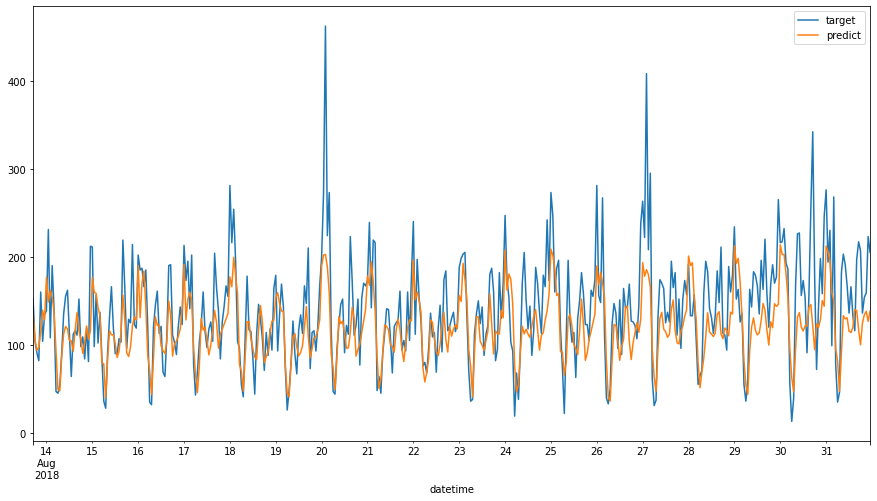

In [24]:
model_lgbm = lgb.LGBMRegressor(random_state = RANDOM_STATE, max_depth=7, n_estimators=40, num_leaves=40)
model_lgbm.fit(features_train, target_train)
display(f'RMSE на тестовой выборке={mean_squared_error(target_test, model_lgbm.predict(features_test))**0.5}')
graphics(model_lgbm, target_test, features_test)

<b>Вывод:</b>
   - на первом этапе произведена выгрузка и анализ данных
   - на втором этапе произведён анализ данных по времени, опеределены тренды и сезонность. Наблюбдается спад заказов в ночное время и пик макисмума в вечернее время
   - подобраны гиперпараметры и обучены модели LinearRegrtession, RandomForest, LightGBM, выбрана лучшая модель по значению rmse
   -  лучшая модель  протестированна на тренировочной выбрке LightGbm rmse=45.29